Лабораторна робота №2

з курсу 'Основи технологій машинного навчання'

Класифікація видів об’єктів.

Предментна область: М'ячі.

Види: 1)футбольні; 2)баскетбольні; 3)тенісні.

Виконав: студент групи ТІ-72

Бортнічук Нікіта Олександрович

Виконано у сервісі gradient

In [45]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [4]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [5]:
results = search_images_bing('50e7821fe35c4bc1a5307c5533bf738d', 'soccer ball')
ims = results.attrgot('contentUrl') # in new bing use camelCase
len(ims)

150

In [6]:
results

(#150) [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=soccer+ball&id=0BCEF73CCD6B00EA224E7D6A8F61EB0363756ADD&simid=608033624296654946', 'name': 'The evolution of the soccer ball - Active For Life', 'thumbnailUrl': 'https://tse3.mm.bing.net/th?id=OIP.3Iga_qdRTRZiCsRG3y00sQHaE8&pid=Api', 'datePublished': '2018-07-09T10:21:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'https://activeforlife.com/content/uploads/2018/07/soccer-ball-2121x1414.jpg', 'hostPageUrl': 'https://activeforlife.com/the-evolution-of-the-soccer-ball/', 'contentSize': '471530 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'https://activeforlife.com/the-evolution-of-the-soccer-ball', 'width': 2121, 'height': 1415, 'hostPageFavIconUrl': 'https://www.bing.com/th?id=ODF.9pOKWuvAEGEHpI2ZFmiS-w&pid=Api', 'hostPageDiscoveredDate': '2018-07-09T10:21:00.0000000Z', 'thumbnail': {'width': 474, 'height': 316}, 'imageInsightsToken': 'ccid_3Iga/qdR*cp_C0B5D25D5EED71C2B664CA2B42218B34*m

In [7]:
ims[0]

'https://activeforlife.com/content/uploads/2018/07/soccer-ball-2121x1414.jpg'

In [8]:
dest = 'images/soccer.jpg'
download_url(ims[0], dest)

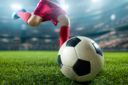

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
ball_types = 'soccer','basketball','tennis'
path = Path('balls')

In [11]:
if not path.exists():
    path.mkdir()
    for o in ball_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing('50e7821fe35c4bc1a5307c5533bf738d', f'{o} ball')
        download_images(dest, urls=results.attrgot('contentUrl')) #

In [12]:
fns = get_image_files(path)
fns

(#447) [Path('balls/soccer/00000002.jpg'),Path('balls/soccer/00000001.jpg'),Path('balls/soccer/00000000.jpg'),Path('balls/soccer/00000007.jpg'),Path('balls/soccer/00000009.jpg'),Path('balls/soccer/00000004.jpg'),Path('balls/soccer/00000012.jpg'),Path('balls/soccer/00000010.jpg'),Path('balls/soccer/00000013.jpg'),Path('balls/soccer/00000006.png')...]

In [13]:
failed = verify_images(fns)
failed

(#8) [Path('balls/soccer/00000004.jpg'),Path('balls/soccer/00000022.png'),Path('balls/soccer/00000045.jpg'),Path('balls/soccer/00000051.png'),Path('balls/soccer/00000132.png'),Path('balls/soccer/00000148.png'),Path('balls/basketball/00000107.jpg'),Path('balls/basketball/00000129.jpg')]

In [14]:
failed.map(Path.unlink);

In [15]:
balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = balls.dataloaders(path)

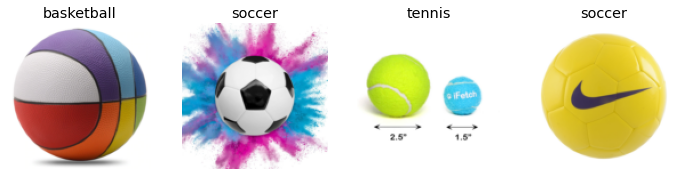

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

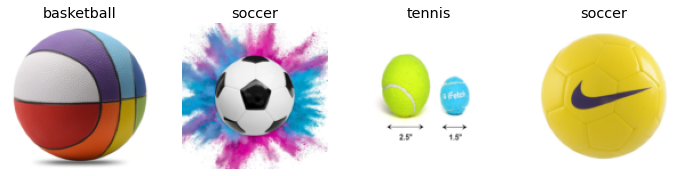

In [18]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

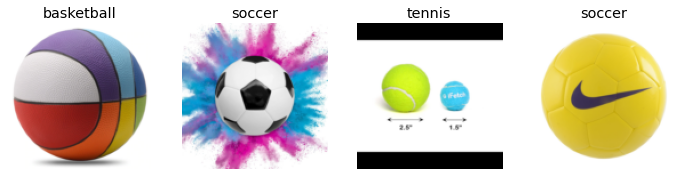

In [19]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

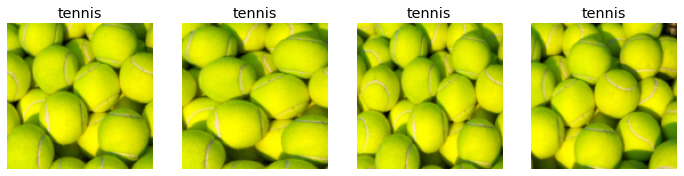

In [20]:
balls = balls.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

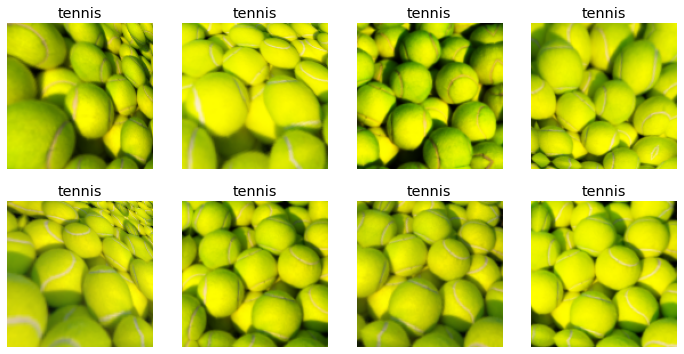

In [21]:
#data augmentation
balls = balls.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
# Training Your Model, and Using It to Clean Your Data
balls = balls.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = balls.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.418251,0.247346,0.091954,00:07


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.318825,0.037310,0.011494,00:09
1,0.219097,0.009093,0.000000,00:09
2,0.158299,0.006641,0.000000,00:09
3,0.124251,0.008440,0.000000,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


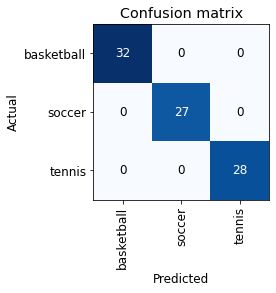

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

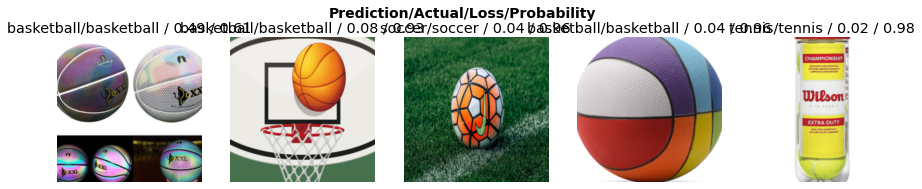

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [27]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
# Turning Your Model into an Online Application
# Using the Model for Inference
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('images/soccer.jpg')

('soccer', TensorImage(1), TensorImage([5.8737e-06, 9.9999e-01, 4.3697e-06]))

In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
btn_upload = SimpleNamespace(data = ['images/soccer.jpg'])

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: soccer; Probability: 1.0000')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
btn_upload = widgets.FileUpload()

VBox([widgets.Label('Select your ball!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [43]:
#Turning Your Notebook into a Real App

!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 1.9 MB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 30.1 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 66.2 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.4 OK
